# Multi-dimensional Functions {#sec-multi-dim}


This chapter illustrates how high-dimensional functions can be optimized and analyzed.

## Example: `Spot` and the 3-dim Sphere Function


In [1]:
import numpy as np
from spotPython.fun.objectivefunctions import analytical
from spotPython.utils.init import fun_control_init, surrogate_control_init
from spotPython.spot import spot

Seed set to 123


### The Objective Function: 3-dim Sphere

The `spotPython` package provides several classes of objective functions.
We will use an analytical objective function, i.e., a function that can be described by a (closed) formula:
$$
f(x) = \sum_i^k x_i^2.
$$ 
   
It is avaliable as `fun_sphere` in the `analytical` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/objectivefunctions.py).


In [2]:
fun = analytical().fun_sphere

Here we will use problem dimension $k=3$, which can be specified by the `lower` bound arrays.
The size of the `lower` bound array determines the problem dimension. If we select `-1.0 * np.ones(3)`, a three-dimensional function is created.
In contrast to the one-dimensional case (@sec-visualizing-tensorboard-01), where only one `theta` value was used, we will use three different `theta` values (one for each dimension), i.e., we set `n_theta=3` in the `surrogate_control`.
The prefix is set to `"03"` to distinguish the results from the one-dimensional case.
Again, TensorBoard can be used to monitor the progress of the optimization.

We can also add interpreable labels to the dimensions, which will be used in the plots. Therefore, we set `var_name=["Pressure", "Temp", "Lambda"]` instead of the default `var_name=None`, which would result in the labels `x_0`, `x_1`, and `x_2`.


In [3]:
fun_control = fun_control_init(
              PREFIX="03",
              lower = -1.0*np.ones(3),
              upper = np.ones(3),
              var_name=["Pressure", "Temp", "Lambda"],
              show_progress=True)
surrogate_control = surrogate_control_init(n_theta=3)
spot_3 = spot.Spot(fun=fun,
                  fun_control=fun_control,
                  surrogate_control=surrogate_control)
spot_3.run()

Seed set to 123


Created spot_tensorboard_path: runs/spot_logs/03_p040025_2024-01-13_20-27-36 for SummaryWriter()


spotPython tuning: 0.03443324167631616 [#######---] 73.33% 


spotPython tuning: 0.03134655155643102 [########--] 80.00% 


spotPython tuning: 0.0009630181526749273 [#########-] 86.67% 


spotPython tuning: 8.570154459856623e-05 [#########-] 93.33% 


spotPython tuning: 6.496172516667557e-05 [##########] 100.00% Done...



::: {.callout-note}
Now we can start TensorBoard in the background with the following command:



```{raw}
tensorboard --logdir="./runs"
```


and can access the TensorBoard web server with the following URL:



```{raw}
http://localhost:6006/
```


::: 

### Results


In [4]:
_ = spot_3.print_results()

min y: 6.496172516667557e-05
Pressure: 0.005280070995399376
Temp: 0.0019490323308060742
Lambda: 0.005769215581315232


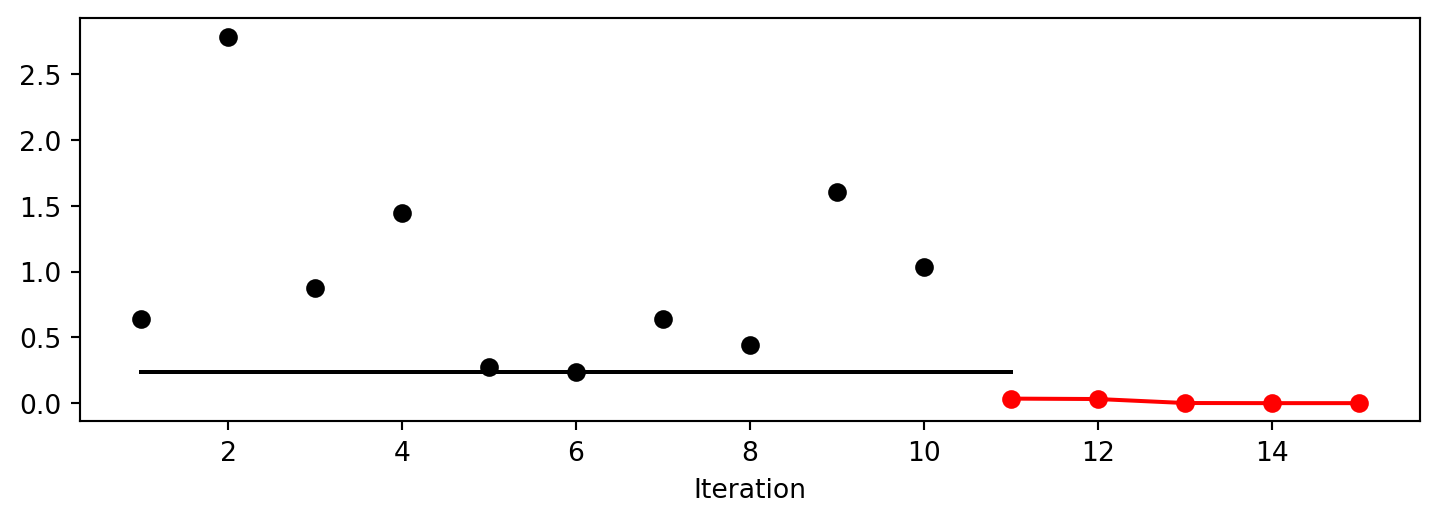

In [5]:
spot_3.plot_progress()

### A Contour Plot

We can select two dimensions, say $i=0$ and $j=1$, and generate a contour plot as follows.

::: {.callout-note}
#### Note: 

We have specified identical `min_z` and `max_z` values to generate comparable plots.

:::


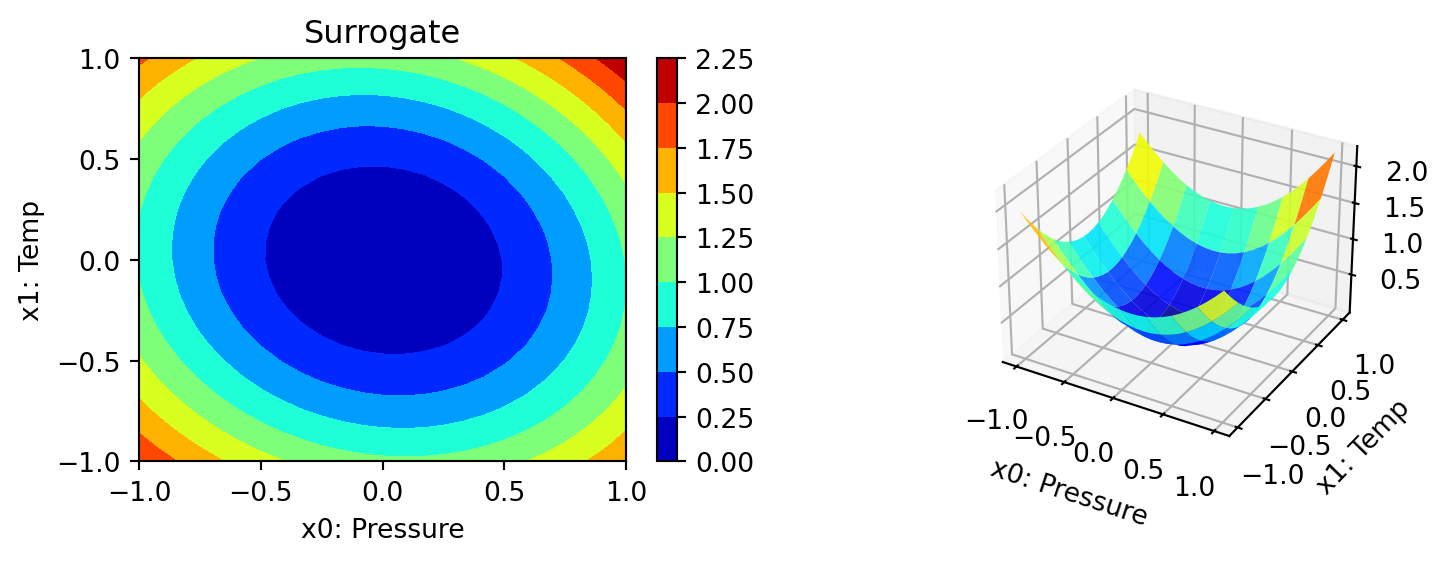

In [6]:
spot_3.plot_contour(i=0, j=1, min_z=0, max_z=2.25)

* In a similar manner, we can plot dimension $i=0$ and $j=2$:


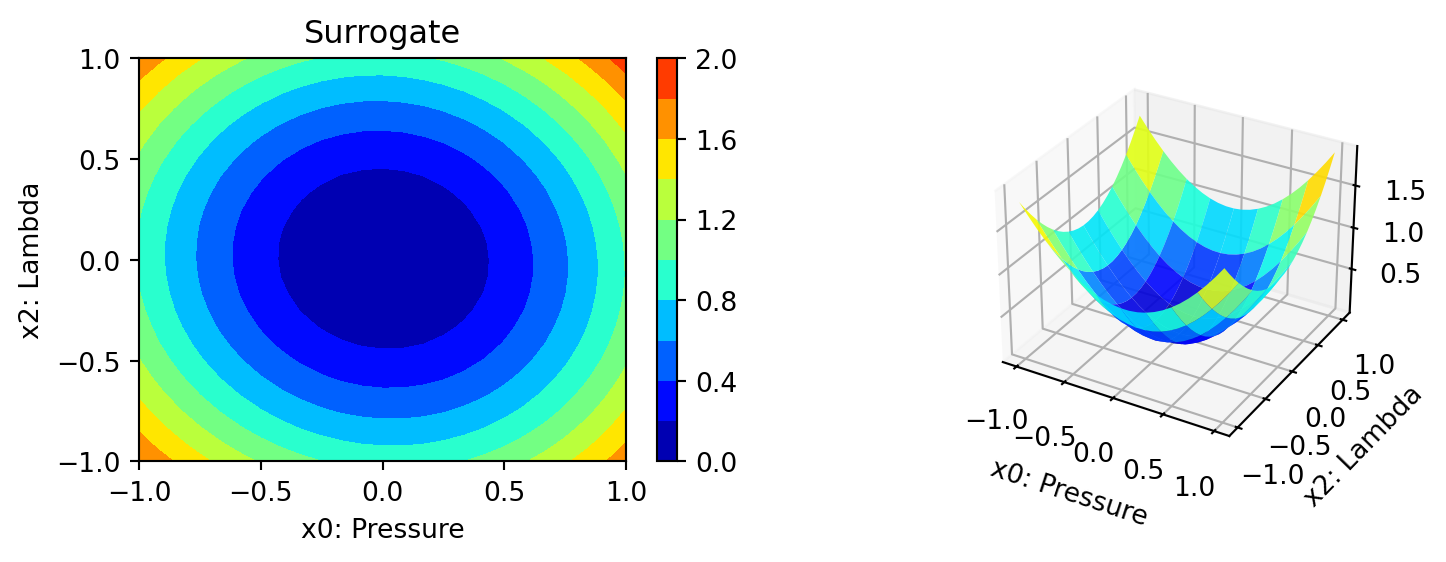

In [7]:
spot_3.plot_contour(i=0, j=2, min_z=0, max_z=2.25)

* The final combination is $i=1$ and $j=2$:


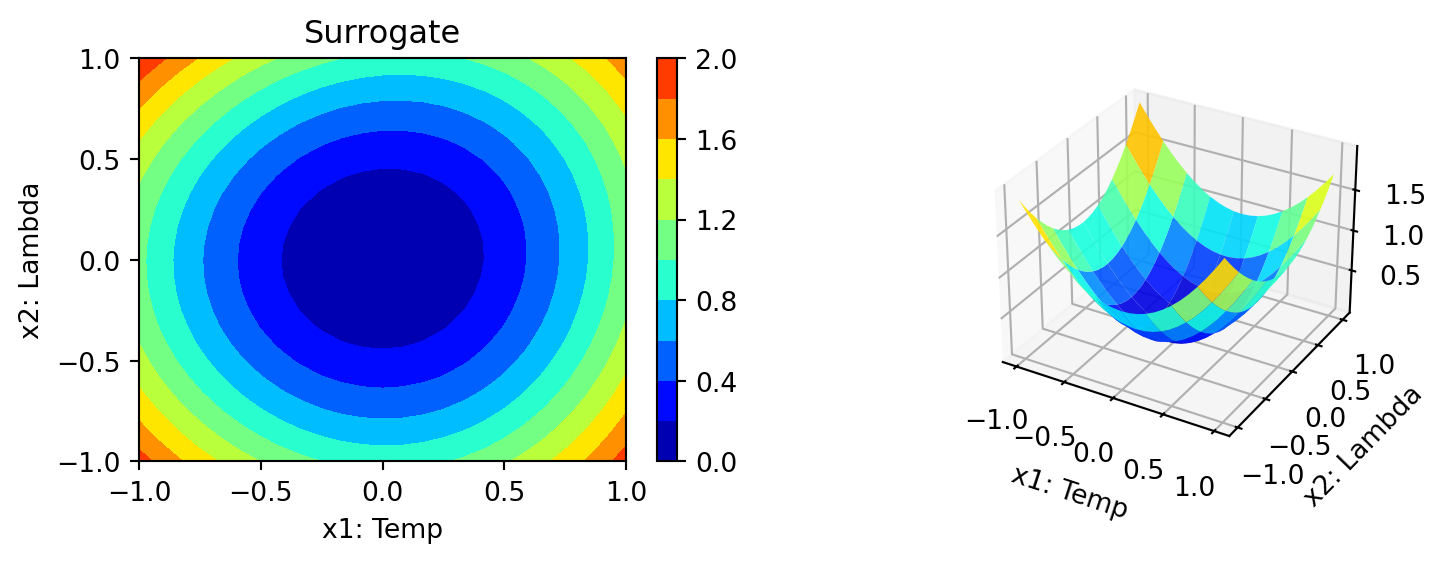

In [8]:
spot_3.plot_contour(i=1, j=2, min_z=0, max_z=2.25)

* The three plots look very similar, because the `fun_sphere` is symmetric.
* This can also be seen from the variable importance:


In [9]:
_ = spot_3.print_importance()

Pressure:  95.79368533570627
Temp:  99.99999999999999
Lambda:  87.19542775477797


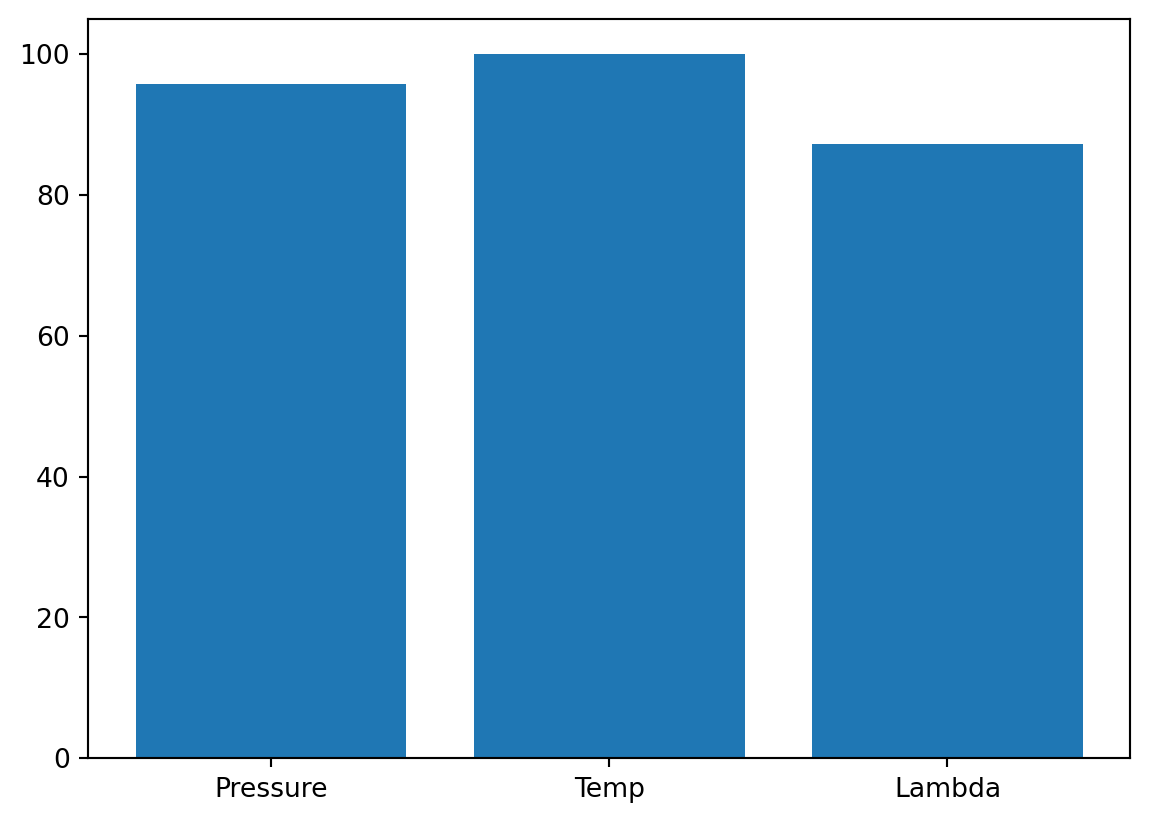

In [10]:
spot_3.plot_importance()

### TensorBoard

![TensorBoard visualization of the spotPython process. Objective function values plotted against wall time.](figures_static/02_tensorboard_01.png)

The second TensorBoard visualization shows the input values, i.e., $x_0, \ldots, x_2$, plotted against the wall time.
![TensorBoard visualization of the spotPython process.](figures_static/02_tensorboard_02.png)

The third TensorBoard plot illustrates how `spotPython` can be used as a microscope for the internal mechanisms of the surrogate-based optimization process. Here, one important parameter, the learning rate $\theta$ of the Kriging surrogate is plotted against the number of optimization steps.

![TensorBoard visualization of the spotPython surrogate model.](figures_static/02_tensorboard_03.png){width="100%"}


## Conclusion

Based on this quick analysis, we can conclude that all three dimensions are equally important (as expected, because the analytical function is known).

## Exercises

* Important:
    * Results from these exercises should be added to this document, i.e., you should submit an updated version of this notebook.
    * Please combine your results using this notebook.
    * Presentation is based on this notebook. No addtional slides are required!
    * spotPython version `0.10.15` (or greater) is required 

### The Three Dimensional `fun_cubed`

* The input dimension is `3`. The search range is  $-1 \leq x \leq 1$ for all dimensions.
* Generate contour plots
* Calculate the variable importance.
* Discuss the variable importance: 
  * Are all variables equally important? 
  * If not: 
    * Which is the most important variable?
    * Which is the least important variable?

### The Ten Dimensional `fun_wing_wt`

* The input dimension is `10`. The search range is  $0 \leq x \leq 1$ for all dimensions.
* Calculate the variable importance.
* Discuss the variable importance: 
  * Are all variables equally important? 
  * If not: 
    * Which is the most important variable?
    * Which is the least important variable?
  * Generate contour plots for the three most important variables. Do they confirm your selection?

### The Three Dimensional `fun_runge`

* The input dimension is `3`. The search range is  $-5 \leq x \leq 5$ for all dimensions.
* Generate contour plots
* Calculate the variable importance.
* Discuss the variable importance: 
  * Are all variables equally important? 
  * If not: 
    * Which is the most important variable?
    * Which is the least important variable?

### The Three Dimensional `fun_linear`

* The input dimension is `3`. The search range is  $-5 \leq x \leq 5$ for all dimensions.
* Generate contour plots
* Calculate the variable importance.
* Discuss the variable importance: 
  * Are all variables equally important? 
  * If not: 
    * Which is the most important variable?
    * Which is the least important variable?


## Jupyter Notebook

:::{.callout-note}

* The Jupyter-Notebook of this lecture is available on GitHub in the [Hyperparameter-Tuning-Cookbook Repository](https://github.com/sequential-parameter-optimization/Hyperparameter-Tuning-Cookbook/blob/main/008_num_spot_multidim.ipynb)

:::